In [16]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

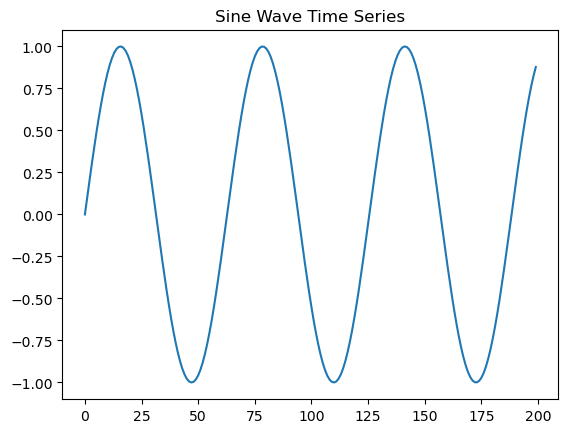

In [17]:
def generate_data(seq_length=1000):
    x = np.linspace(0, 100, seq_length)
    y = np.sin(x)
    return y

data = generate_data()

In [18]:
def create_sequences(data, seq_length):
    X, Y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        Y.append(data[i + 1:i + seq_length + 1])  # Shift by 1 step
    return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

seq_length = 20
X, Y = create_sequences(data, seq_length)

X = X.unsqueeze(-1)
Y = Y.unsqueeze(-1)

train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

In [19]:
class TransformerTimeSeries(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, dropout=0.1):
        super(TransformerTimeSeries, self).__init__()
        self.model_dim = model_dim

        self.transformer = nn.Transformer(
            d_model=model_dim, 
            nhead=num_heads, 
            num_encoder_layers=num_layers, 
            num_decoder_layers=num_layers,
            dropout=dropout
        )

        self.input_fc = nn.Linear(input_dim, model_dim)
        self.output_fc = nn.Linear(model_dim, input_dim)

    def forward(self, src, tgt):
        src = self.input_fc(src)
        tgt = self.input_fc(tgt)  

        src = src.permute(1, 0, 2)
        tgt = tgt.permute(1, 0, 2)

        output = self.transformer(src, tgt)

        output = self.output_fc(output.permute(1, 0, 2))
        return output

input_dim = 1
model_dim = 64
num_heads = 4
num_layers = 2
dropout = 0.1

model = TransformerTimeSeries(input_dim, model_dim, num_heads, num_layers)

C:\Users\naman\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [20]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train, X_train)
    loss = criterion(output, Y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 10/50, Loss: 0.3951
Epoch 20/50, Loss: 0.1021
Epoch 30/50, Loss: 0.0654
Epoch 40/50, Loss: 0.0348
Epoch 50/50, Loss: 0.0264


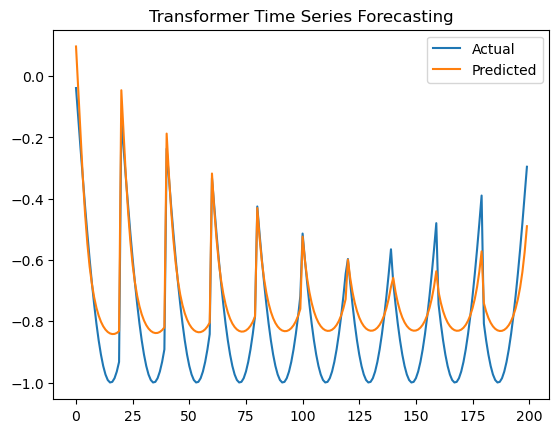

In [21]:
model.eval()
with torch.no_grad():
    Y_pred = model(X_test, X_test)

Y_test_np = Y_test.numpy().flatten()
Y_pred_np = Y_pred.numpy().flatten()

plt.plot(Y_test_np[:200], label="Actual")
plt.plot(Y_pred_np[:200], label="Predicted")
plt.legend()
plt.title("Transformer Time Series Forecasting")
plt.show()